# Train a Simplifed LeNet5 NoPool to classify CIFAR-10 data



LeNet5 is a well know model which was intruced inpaper "Gradient-based learning applied to document recognitio" by LeCun in1998. In the paer itis ued to classify theMNIST handscripts numbers. Herewe will train asimplified LeNet5 model to clasify CIFAR-10 data.



# CIFAR-10 dataset

The CIFAR-10 datase consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images nd 10000 test images. 

The dataset is divided into fivetrainig batches andone test batch, each with 10000 images. The test batch ontains exactly 1000 randomly-selected images from each class. The training batches contain theremaining mages in random order, but some training batches may contain more images from one clas thananother. Betwen them, the training batches contain exactly 5000 images from each class. 


Here are the classes in the dataset, as well as 10 random images from each:

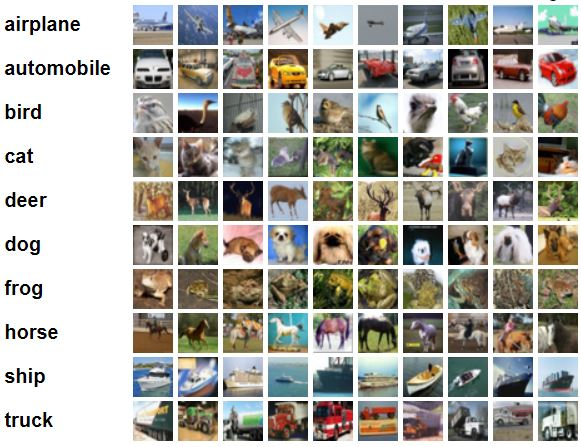

For more information, please refer to below link.

http://www.cs.toronto.edu/~kriz/cifar.html

## Section 1 Define Super Training Parameters

- epoch: define the iteration of the train
- batch_size: define the train batch size. It depends on how large the memory is. CIFAR-10 is a very small images. 200 - 500 should be good. 
- test_size: define the test batch size.  
- learn rate (lr): The start learn rate for Agagrad
- keep_prob: the probability of the training parameter
- augument: To have a better training effect, the image augument is always True

In [1]:
from cifar10 import cifar10
import os
import tensorflow as tf
import tf_general as tfg
import numpy as np
from train_log import train_log

FLAGS = tf.flags.FLAGS

try:
    #Super parameter definition
    tf.flags.DEFINE_string('f', '', 'kernel')
    tf.flags.DEFINE_integer('epoch', 30000, 'epoch')
    tf.flags.DEFINE_integer('batch_size',500, 'batch size')
    tf.flags.DEFINE_integer('test_size', 500, 'test size')
    tf.flags.DEFINE_float('lr', 0.01, 'learning rate')
    tf.flags.DEFINE_float('drop_rate', 0.3, 'drop out rate for drop lay')
    tf.flags.DEFINE_boolean('augument', True, 'if image augument is applied') 
    #Other training parameter                        
    tf.flags.DEFINE_float('ckpt_frequency', 125, 'frequency to save checkpoint')
    tf.flags.DEFINE_boolean('restore', False, 'restore from checkpoint and run test')
    print('parameters were defined.')
except:
    print('parameters have been defined.')

print("learn Rate =",FLAGS.lr, "drop rate=", FLAGS.drop_rate, " image augument=",FLAGS.augument)   
CONTINUE = 0
RUN = 2

parameters were defined.
learn Rate = 0.01 drop rate= 0.3  image augument= True


## Section 2. Generate Checkpoint dir and Log dir

- Checkpoint dir is saved in variable **../Le-Net5-Log/Le-Net5_CLASS/ckpt_RUN**, if the dir doesn't exist then create it. 
- Log file dir is saved in variable **../Le-Net5-Log/Le-Net5_CLASS/log_RUN**, if the dir doesn't exist then create it. 
- data_path is the position of the CIFAR-10 image data
The reason to save the model and log outside the project is to avoid effect the git code management.

In [2]:
ckpt_dir = '../Le-Net5-Log/Le-Net5_NOPOOL/ckpt_'+str(RUN)+'/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

log_dir = '../Le-Net5-Log/Le-Net5_NOPOOL/log_'+str(RUN)+'/'
log = train_log(log_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

data_path = '../cifar-10-batches-py/'
if not os.path.exists(data_path):
    print('The data path doesn\'t exist. Please check if it is a correct data path.')

## Section 3. Modified LeNet5 
This is a modified LeNet5 model. A lot of details are ignored in the model.Below is the architecture of the LeNet5 we implemented. It is a little bit different from the original one as some detail design were removed.  

![image.png](attachment:image.png)

In [3]:
class LeNet5(object):
    def __init__(self, x, n_class=10, drop_rate=0):
        self.input = x
        self.n_class = n_class
        self.drop_rate = drop_rate
        self._build_net()

    def _build_net(self):
        with tf.name_scope('norm'):    
            self.x_norm = tf.nn.l2_normalize(tf.cast(self.input, tf.float32),axis=1)
        
        with tf.name_scope('conv_1'):
            self.conv1 = tfg.conv2d(self.x_norm, 3, 1, 6, 'conv1', 'VALID','RELU')
            print('conv_1: ', self.conv1.get_shape())    
        
        with tf.name_scope('pool_1'):
            self.pool1 = tfg.avg_pool(self.conv1, 1, 1, 'pool1', 'VALID')
            print('pool_1: ', self.pool1.get_shape())
              
        with tf.name_scope('conv_2'):
            self.conv2 = tfg.conv2d(self.pool1, 3, 1, 16, 'conv2', 'VALID','RELU')
            print('conv_2: ', self.conv2.get_shape())
        
        with tf.name_scope('pool_2'):
            self.pool2 = tfg.avg_pool(self.conv2, 1, 1, 'pool2', 'VALID')
            print('pool_2: ', self.pool2.get_shape())   
            
        with tf.name_scope('conv_3'):
            self.conv3 = tfg.conv2d(self.pool2, 3, 1, 120, 'conv3', 'VALID','RELU')
            print('conv_3:', self.conv3.get_shape())
        
        with tf.name_scope('flat_1'):
            self.flat1, self.flat_dim = tfg.flatten(self.conv3)
            print('flat_1:', self.flat1.get_shape())
        
        with tf.name_scope('fc_2'):
            self.fc2 = tfg.fc_layer(self.flat1, self.flat_dim, 840, 'fc2','RELU')
            print('fc_2 ', self.fc2.get_shape())
        
        with tf.name_scope('fc_3'):
            self.fc3 = tfg.fc_layer(self.fc2, 840, 10, 'fc4','RELU')
            print('fc_3: ', self.fc3.get_shape())

        with tf.name_scope('drop_out'):
            self.drop1 = tfg.drop_out(self.fc3, self.drop_rate, 'drop_out')
            print('drop_out: ', self.drop1.get_shape())

        with tf.name_scope('prediction'):
            self.prediction = tf.nn.softmax(self.drop1)
            print('prediction: ', self.prediction.get_shape())

## Section 4. Build the calculation graph

### 4.1 Input layer 

Use the data feeder to provide the training data. Therefore we define a placeholder with the same structure of the input data. 
The CIFAR-10 data is 60000 RGB images with each size is 32x32. The data structure should be[batchsize, 32,32,3]. Input channels are 3.  

In [4]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None,32,32,3], name='x_input')
    drop_rate = tf.placeholder(tf.float32, name='drop_rate')
    y_ = tf.placeholder(tf.int64, [None], name='labels')

### 4.2 Deifne the LeNet5 object

Use the previously defined LeNet5 class to build LeNet5 network.
y is the output of the LeNet5 network. 

In [5]:
with tf.name_scope('prediction'):
    le_net5 = LeNet5(x, drop_rate)
    y = le_net5.prediction

conv_1:  (?, 30, 30, 6)
pool_1:  (?, 30, 30, 6)
conv_2:  (?, 28, 28, 16)
pool_2:  (?, 28, 28, 16)
conv_3: (?, 26, 26, 120)
flat_1: (?, 81120)
fc_2  (?, 840)
fc_3:  (?, 10)
drop_out:  (?, 10)
prediction:  (?, 10)


### 4.3 Calculate the cross entropy as the loss
Use the cross entropy as the loss. 
**cross entropy** is normally used as the loss of the network. 
$$cross\_entropy(output, label) = \sum_i{output_i*log(label_i)}$$

tensorflow function **sparse_softmax_cross_entropy_with_logits** calculate the cross entropy with the logits which is one hot output from the network and the label which is a interger number.

In [6]:
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y,
                                                                          labels=y_, 
                                                                          name="cross_entropy_per_example"))

### 4.4 Use Adagrad to minimize the loss

In [7]:
with tf.name_scope('train_step'):
    train_step = tf.train.AdagradOptimizer(FLAGS.lr).minimize(cross_entropy)

### 4.5 Calculate the reduce mean as the accuracy

In [8]:
with tf.name_scope('train_accuracy'):
    prediction =tf.argmax(y, 1)
    accuracy = tf.reduce_mean(tf.cast( tf.equal(prediction,y_), tf.float32))

## Now, let's start the training...

In [9]:
import time

data = cifar10(data_path);

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=1)
    if CONTINUE != 0:
        model_file=tf.train.latest_checkpoint(ckpt_dir)
        saver.restore(sess,model_file)
    for i in range(CONTINUE, FLAGS.epoch):
        train_image, train_label,_ = data.get_train_batch(FLAGS.batch_size,FLAGS.augument)
        loss, _,accuracy_rate = sess.run([cross_entropy, train_step, accuracy], 
                                         feed_dict={drop_rate: FLAGS.drop_rate, x:train_image, y_:train_label})
        print('.',end='')    
        log.add_log('train_accuracy',i, accuracy_rate)
        log.add_log('train_loss',i, loss)
        if (i+1) % FLAGS.ckpt_frequency == 0:  #保存预测模型
            saver.save(sess,ckpt_dir+'cifar10_'+str(i+1)+'.ckpt',global_step=i+1)
            acc_accuracy = 0
            for j in range(int(10000/FLAGS.test_size)):                    
                test_image, test_label,test_index = data.get_test_batch(FLAGS.test_size)
                accuracy_rate, output = sess.run([accuracy,prediction],
                                                 feed_dict={drop_rate: 0, x:test_image, y_:test_label})
                acc_accuracy += accuracy_rate
                log.add_log('test_index',i, test_index)
                log.add_log('output',i, output)
            accuracy_rate = acc_accuracy/10000*FLAGS.test_size
            print()
            print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + 
                  ' iter ' + str(i) + ', Test accuracy:' +str(round(accuracy_rate*100,2))+'%')
            log.add_log('test_accuracy',i, accuracy_rate)
            log.SaveToFile()
    tf.reset_default_graph()

train set length: 50000
test set length: 10000
.............................................................................................................................
2019-06-19 23:03:41 iter 124, Test accuracy:10.17%
.............................................................................................................................
2019-06-19 23:16:45 iter 249, Test accuracy:12.57%
.............................................................................................................................
2019-06-19 23:30:29 iter 374, Test accuracy:10.57%
.............................................................................................................................
2019-06-19 23:46:53 iter 499, Test accuracy:13.68%
.............................................................................................................................
2019-06-20 00:00:32 iter 624, Test accuracy:19.67%
....................................................................

.............................................................................................................................
2019-06-20 10:48:31 iter 5874, Test accuracy:32.61%
.............................................................................................................................
2019-06-20 11:05:19 iter 5999, Test accuracy:32.46%
.............................................................................................................................
2019-06-20 11:18:15 iter 6124, Test accuracy:32.74%
.............................................................................................................................
2019-06-20 11:31:17 iter 6249, Test accuracy:32.99%
.............................................................................................................................
2019-06-20 11:44:45 iter 6374, Test accuracy:32.55%
..............................................................................................................

.............................................................................................................................
2019-06-20 21:44:45 iter 11624, Test accuracy:35.95%
.............................................................................................................................
2019-06-20 21:57:42 iter 11749, Test accuracy:37.12%
.............................................................................................................................
2019-06-20 22:11:27 iter 11874, Test accuracy:37.14%
.............................................................................................................................
2019-06-20 22:27:00 iter 11999, Test accuracy:37.66%
.............................................................................................................................
2019-06-20 22:39:52 iter 12124, Test accuracy:37.31%
.........................................................................................................

.............................................................................................................................
2019-06-21 08:29:36 iter 17374, Test accuracy:39.43%
.............................................................................................................................
2019-06-21 08:48:08 iter 17499, Test accuracy:38.8%
.............................................................................................................................
2019-06-21 09:01:24 iter 17624, Test accuracy:40.0%
.............................................................................................................................
2019-06-21 09:14:50 iter 17749, Test accuracy:40.01%
.............................................................................................................................
2019-06-21 09:28:30 iter 17874, Test accuracy:40.34%
...........................................................................................................

.............................................................................................................................
2019-06-21 19:27:12 iter 23124, Test accuracy:42.62%
.............................................................................................................................
2019-06-21 19:40:12 iter 23249, Test accuracy:43.9%
.............................................................................................................................
2019-06-21 19:54:01 iter 23374, Test accuracy:43.69%
.............................................................................................................................
2019-06-21 20:11:01 iter 23499, Test accuracy:44.17%
.............................................................................................................................
2019-06-21 20:25:11 iter 23624, Test accuracy:44.55%
..........................................................................................................

.............................................................................................................................
2019-06-22 06:18:06 iter 28874, Test accuracy:45.29%
.............................................................................................................................
2019-06-22 06:34:15 iter 28999, Test accuracy:45.39%
.............................................................................................................................
2019-06-22 06:47:39 iter 29124, Test accuracy:45.57%
.............................................................................................................................
2019-06-22 07:00:47 iter 29249, Test accuracy:46.21%
.............................................................................................................................
2019-06-22 07:14:14 iter 29374, Test accuracy:46.56%
.........................................................................................................

AssertionError: Do not use tf.reset_default_graph() to clear nested graphs. If you need a cleared graph, exit the nesting and create a new graph.